In [1]:
# =========================================================
# PhysicsPrior notebook bootstrap via module import
# =========================================================
import importlib.util
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import torch
import torch.nn as nn
from contextlib import nullcontext
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix
from tqdm import tqdm

repo_root = pathlib.Path.cwd()
module_path = repo_root / "mNDWS_models copy.py"
print(f"Loading shared models module from: {module_path}")
spec = importlib.util.spec_from_file_location("mndws_models_copy", module_path)
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)
sys.modules["mndws_models_copy"] = models

set_seed = models.set_seed
set_seed(1337)

device = models.device
use_cuda = models.use_cuda
use_mps = models.use_mps
print("Device:", device)

Loading shared models module from: /sfs/weka/scratch/jbm2rt/DS6050/wildfire-spread-prediction/mNDWS_models copy.py
Device: cuda
Artifacts -> /home/jbm2rt/wildfire_artifacts/resnet18_unet
Reusing NPZ tiles from pipeline at: /scratch/jbm2rt/wildfire_npz_tiles_mndws_v1
Device: cuda


In [2]:
# --- Reuse pipeline + loader configuration from shared module ---
BATCH_SIZE = 16
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = models.pipeline_hookup(
    BATCH_SIZE=BATCH_SIZE
)
CHANNELS_FOR_MODEL = list(train_ds.channels)
print(f"Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}")

DataLoader workers -> train: 8, val: 0, test: 0; pin_memory=True
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']


In [3]:
# =========================================================
# PhysicsPrior UNet bundle + optimizer/criterion setup
# =========================================================
pos_weight = models.pos_weight_from_loader(train_loader)

bundle = models.build_physics_unet_bundle(
    CHANNELS_FOR_MODEL,
    meanC,
    stdC,
    base_width=80,
    ema_decay=0.999,
    loss_type="hybrid",  # combines focal + Tversky
    loss_kwargs={
        "pos_weight": pos_weight,
        "focal_alpha": 0.25,
        "focal_gamma": 2.0,
        "focal_weight": 0.5,  # 0→pure Tversky, 1→pure focal
        "tversky_alpha": 0.7,
        "tversky_beta": 0.3,
    },
)
physics_model = bundle["model"]
feature_builder = bundle["feature_builder"]
ema_tracker = bundle["ema"]
polyak_tracker = bundle["polyak"]
criterion = bundle["criterion"]

optimizer = torch.optim.AdamW(physics_model.parameters(), lr=2e-4, weight_decay=1e-4)
amp_enabled = use_cuda
scaler = torch.amp.GradScaler(device="cuda", enabled=amp_enabled)
if amp_enabled:
    def autocast_ctx():
        return torch.amp.autocast(device_type="cuda")
else:
    autocast_ctx = nullcontext
amp_stream = autocast_ctx

print(f"pos_weight = {float(pos_weight):.3f}")
print(
    f"Model parameters: {sum(p.numel() for p in physics_model.parameters() if p.requires_grad)/1e6:.2f} M"
)
print(f"Loss config: {bundle['loss_config']}")

PhysicsPrior UNet init -> in:16 base:80 | parameters: 12.04 M
pos_weight = 32.897
Model parameters: 12.04 M
Loss config: {'type': 'hybrid', 'kwargs': {'pos_weight': tensor(32.8968, device='cuda:0'), 'focal_alpha': 0.25, 'focal_gamma': 2.0, 'focal_weight': 0.5, 'tversky_alpha': 0.7, 'tversky_beta': 0.3}}


In [4]:
# =========================================================
# Train / Eval loops for PhysicsPrior UNet
# =========================================================
EPOCHS_PHYSICS = 50
amp_stream = autocast_ctx

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist = [], [], [], []
best_val_ap = -1.0
best_state = None

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in physics_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)


def _forward_batch(model_obj, batch):
    X_raw = batch["X_raw"].to(device, non_blocking=True)
    y = batch["y"].to(device, non_blocking=True)
    feats = feature_builder(X_raw)
    return feats, y


def train_physics_epoch():
    physics_model.train()
    losses = []
    tiles_seen = 0
    for batch in tqdm(train_loader, desc="train Physics", leave=False):
        feats, y = _forward_batch(physics_model, batch)
        optimizer.zero_grad(set_to_none=True)
        with amp_stream():
            logits = physics_model(feats)
            loss = criterion(logits, y)
        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        ema_tracker.update(physics_model)
        polyak_tracker.update(physics_model)
        losses.append(loss.item())
        tiles_seen += feats.size(0)
    return float(np.mean(losses)), tiles_seen


@torch.no_grad()
def eval_physics(model_obj, loader, desc="eval Physics"):
    model_obj.eval()
    all_p, all_t = [], []
    for batch in tqdm(loader, desc=desc, leave=False):
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        p = torch.sigmoid(logits).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    return float(ap), float(f1.max()), float(best_thr)


best_thr_val = 0.5

for epoch in range(EPOCHS_PHYSICS):
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_start = time.perf_counter()
    tr_loss, tiles_seen = train_physics_epoch()
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_duration = time.perf_counter() - epoch_start
    epoch_times.append(epoch_duration)
    epoch_tiles.append(tiles_seen)
    ap, f1, thr = eval_physics(physics_model, val_loader)
    train_loss_hist.append(tr_loss)
    val_ap_hist.append(ap)
    val_f1_hist.append(f1)
    val_thr_hist.append(thr)
    print(f"[Physics] Epoch {epoch:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap:
        best_val_ap = ap
        best_state = {k: v.cpu().clone() for k, v in physics_model.state_dict().items()}

if best_state is not None:
    physics_model.load_state_dict(best_state)

best_thr_val = val_thr_hist[-1] if val_thr_hist else 0.5

if epoch_times:
    avg_epoch = float(np.mean(epoch_times))
    std_epoch = float(np.std(epoch_times))
    total_time = float(np.sum(epoch_times))
    total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
    throughput = float(total_tiles / total_time) if total_time > 0 else None
else:
    avg_epoch = std_epoch = throughput = None

if use_cuda:
    torch.cuda.synchronize(device)
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
elif use_mps:
    torch.mps.synchronize()

@torch.no_grad()
def measure_latency(ds, model_obj, repeats=50):
    if len(ds) == 0:
        return None
    model_obj.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    feats = feature_builder(sample)
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(model_obj(feats))
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    return (time.perf_counter() - start) / repeats

latency_s = measure_latency(test_ds, physics_model, repeats=100)

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

[Physics] Epoch 00 | loss 0.5304 | VAL AP 0.3240 | VAL F1* 0.4413 | thr≈0.678


[Physics] Epoch 01 | loss 0.5089 | VAL AP 0.3711 | VAL F1* 0.4576 | thr≈0.661


[Physics] Epoch 02 | loss 0.5017 | VAL AP 0.3515 | VAL F1* 0.4610 | thr≈0.694


[Physics] Epoch 03 | loss 0.4979 | VAL AP 0.4202 | VAL F1* 0.4840 | thr≈0.704


[Physics] Epoch 04 | loss 0.4912 | VAL AP 0.4322 | VAL F1* 0.4840 | thr≈0.668


[Physics] Epoch 05 | loss 0.4882 | VAL AP 0.4284 | VAL F1* 0.4817 | thr≈0.707


[Physics] Epoch 06 | loss 0.4845 | VAL AP 0.4249 | VAL F1* 0.4816 | thr≈0.690


[Physics] Epoch 07 | loss 0.4789 | VAL AP 0.4265 | VAL F1* 0.4840 | thr≈0.704


[Physics] Epoch 08 | loss 0.4764 | VAL AP 0.4193 | VAL F1* 0.4846 | thr≈0.641


[Physics] Epoch 09 | loss 0.4718 | VAL AP 0.4256 | VAL F1* 0.4821 | thr≈0.695


[Physics] Epoch 10 | loss 0.4660 | VAL AP 0.4157 | VAL F1* 0.4800 | thr≈0.710


[Physics] Epoch 11 | loss 0.4594 | VAL AP 0.3821 | VAL F1* 0.4789 | thr≈0.689


[Physics] Epoch 12 | loss 0.4475 | VAL AP 0.4134 | VAL F1* 0.4611 | thr≈0.708


[Physics] Epoch 13 | loss 0.4405 | VAL AP 0.4231 | VAL F1* 0.4893 | thr≈0.639


[Physics] Epoch 14 | loss 0.4324 | VAL AP 0.3888 | VAL F1* 0.4485 | thr≈0.744


[Physics] Epoch 15 | loss 0.4279 | VAL AP 0.4226 | VAL F1* 0.4832 | thr≈0.654


[Physics] Epoch 16 | loss 0.4182 | VAL AP 0.4085 | VAL F1* 0.4727 | thr≈0.674


[Physics] Epoch 17 | loss 0.4144 | VAL AP 0.4285 | VAL F1* 0.4884 | thr≈0.602


[Physics] Epoch 18 | loss 0.4149 | VAL AP 0.4218 | VAL F1* 0.4881 | thr≈0.620


[Physics] Epoch 19 | loss 0.4016 | VAL AP 0.4176 | VAL F1* 0.4768 | thr≈0.684


[Physics] Epoch 20 | loss 0.4067 | VAL AP 0.4117 | VAL F1* 0.4678 | thr≈0.787


[Physics] Epoch 21 | loss 0.4070 | VAL AP 0.4190 | VAL F1* 0.4824 | thr≈0.704


[Physics] Epoch 22 | loss 0.4001 | VAL AP 0.4485 | VAL F1* 0.5111 | thr≈0.644


[Physics] Epoch 23 | loss 0.3915 | VAL AP 0.4275 | VAL F1* 0.4810 | thr≈0.659


[Physics] Epoch 24 | loss 0.3825 | VAL AP 0.4319 | VAL F1* 0.4967 | thr≈0.619


[Physics] Epoch 25 | loss 0.3836 | VAL AP 0.4249 | VAL F1* 0.4802 | thr≈0.573


[Physics] Epoch 26 | loss 0.3761 | VAL AP 0.4332 | VAL F1* 0.4974 | thr≈0.703


[Physics] Epoch 27 | loss 0.3753 | VAL AP 0.4419 | VAL F1* 0.5065 | thr≈0.603


[Physics] Epoch 28 | loss 0.3708 | VAL AP 0.4252 | VAL F1* 0.4883 | thr≈0.687


[Physics] Epoch 29 | loss 0.3651 | VAL AP 0.4339 | VAL F1* 0.4987 | thr≈0.667


[Physics] Epoch 30 | loss 0.3746 | VAL AP 0.4241 | VAL F1* 0.4841 | thr≈0.645


[Physics] Epoch 31 | loss 0.3565 | VAL AP 0.4214 | VAL F1* 0.4896 | thr≈0.655


[Physics] Epoch 32 | loss 0.3535 | VAL AP 0.4280 | VAL F1* 0.4916 | thr≈0.684


[Physics] Epoch 33 | loss 0.3522 | VAL AP 0.4516 | VAL F1* 0.5195 | thr≈0.650


[Physics] Epoch 34 | loss 0.3493 | VAL AP 0.4187 | VAL F1* 0.4825 | thr≈0.658


[Physics] Epoch 35 | loss 0.3519 | VAL AP 0.4530 | VAL F1* 0.5183 | thr≈0.684


[Physics] Epoch 36 | loss 0.3505 | VAL AP 0.4575 | VAL F1* 0.5149 | thr≈0.672


[Physics] Epoch 37 | loss 0.3311 | VAL AP 0.4290 | VAL F1* 0.4940 | thr≈0.632


[Physics] Epoch 38 | loss 0.3329 | VAL AP 0.4605 | VAL F1* 0.5236 | thr≈0.570


[Physics] Epoch 39 | loss 0.3255 | VAL AP 0.4039 | VAL F1* 0.4668 | thr≈0.649


[Physics] Epoch 40 | loss 0.3229 | VAL AP 0.4468 | VAL F1* 0.5036 | thr≈0.696


[Physics] Epoch 41 | loss 0.3172 | VAL AP 0.4570 | VAL F1* 0.5163 | thr≈0.590


[Physics] Epoch 42 | loss 0.3185 | VAL AP 0.4332 | VAL F1* 0.4909 | thr≈0.681


[Physics] Epoch 43 | loss 0.3057 | VAL AP 0.4573 | VAL F1* 0.5194 | thr≈0.637


[Physics] Epoch 44 | loss 0.3012 | VAL AP 0.4765 | VAL F1* 0.5284 | thr≈0.581


[Physics] Epoch 45 | loss 0.2959 | VAL AP 0.4654 | VAL F1* 0.5207 | thr≈0.550


[Physics] Epoch 46 | loss 0.2941 | VAL AP 0.4510 | VAL F1* 0.5112 | thr≈0.699


[Physics] Epoch 47 | loss 0.2833 | VAL AP 0.4669 | VAL F1* 0.5211 | thr≈0.702


[Physics] Epoch 48 | loss 0.2880 | VAL AP 0.4504 | VAL F1* 0.5037 | thr≈0.638


[Physics] Epoch 49 | loss 0.2740 | VAL AP 0.4790 | VAL F1* 0.5340 | thr≈0.648


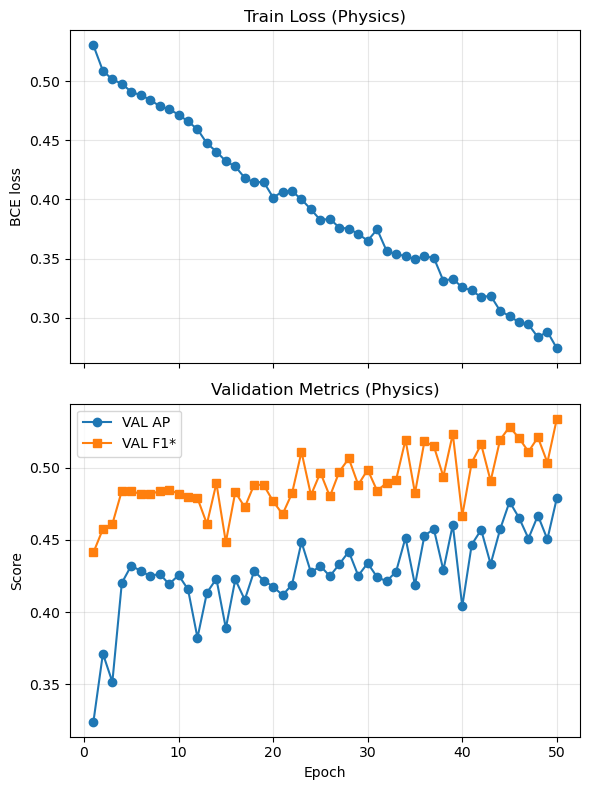

In [5]:
if not train_loss_hist:
    print("Training history empty — rerun the training cell to populate curves.")
else:
    epochs = np.arange(1, len(train_loss_hist) + 1)
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    axes[0].plot(epochs, train_loss_hist, marker="o")
    axes[0].set_title("Train Loss (Physics)")
    axes[0].set_ylabel("BCE loss")
    axes[0].grid(True, alpha=0.3)
    metric_epochs = np.arange(1, len(val_ap_hist) + 1)
    axes[1].plot(metric_epochs, val_ap_hist, marker="o", label="VAL AP")
    axes[1].plot(metric_epochs, val_f1_hist, marker="s", label="VAL F1*")
    axes[1].set_title("Validation Metrics (Physics)")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()

In [6]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[Physics] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[Physics] Computation metrics summary:
  Learnable parameters         12038401
  Avg. epoch wall time         2.101 s
  Epoch time stdev             3.645 s
  Training throughput          571.067 tiles/s
  Peak GPU memory              2.298 GB
  Inference latency (1 tile)   4.419 ms


In [7]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([21, 64, 64])
Height x Width: 64 x 64


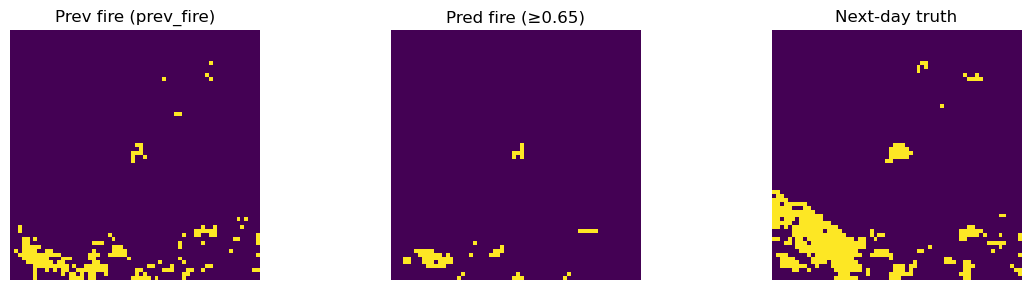

In [8]:
# =========================================================
# Quick qualitative visualization for PhysicsPrior UNet
# =========================================================
@torch.no_grad()
def show_one_physics(ds, model_obj=None, i=0, thr=None):
    if model_obj is None:
        model_obj = physics_model
    if thr is None:
        thr = best_thr_val
    names = ds.channels
    prev_idx = names.index("prev_fire") if "prev_fire" in names else 0
    batch = ds[i]
    X_raw0 = batch["X_raw"].unsqueeze(0).to(device)
    y = batch["y"][0].numpy()
    feats = feature_builder(X_raw0)
    prob = torch.sigmoid(model_obj(feats))[0, 0].cpu().numpy()
    pred_fire = (prob >= float(thr)).astype(np.float32)
    prev_img = batch["X_raw"][prev_idx].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(prev_img, vmin=0, vmax=1)
    axs[0].set_title(f"Prev fire ({names[prev_idx]})")
    axs[1].imshow(pred_fire, vmin=0, vmax=1)
    axs[1].set_title(f"Pred fire (≥{thr:.2f})")
    axs[2].imshow(y, vmin=0, vmax=1)
    axs[2].set_title("Next-day truth")
    for a in axs:
        a.axis('off')
    plt.tight_layout()

# Example
show_one_physics(test_ds, i=0)

In [9]:
# =========================================================
# Save PhysicsPrior artifacts (raw, EMA, Polyak)
# =========================================================
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "physics_unet")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "physics_unet.pt")

artifact = {
    "model": {
        "type": "PhysicsUNet",
        "in_ch": feature_builder.output_channels,
        "base": 80,
    },
    "channels": CHANNELS_FOR_MODEL,
    "state_dict": {k: v.cpu() for k, v in physics_model.state_dict().items()},
    "ema_state_dict": {k: v.cpu() for k, v in ema_tracker.shadow.items()},
    "polyak_state_dict": {k: v.cpu() for k, v in polyak_tracker.shadow.items()},
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /home/jbm2rt/wildfire_artifacts/physics_unet/physics_unet.pt


In [10]:
# =========================================================
# Final validation/test metrics for raw, EMA, Polyak variants
# =========================================================
variants = {"Raw": physics_model}

def _clone_model():
    clone = models.PhysicsUNet(
        in_ch=feature_builder.output_channels,
        out_ch=1,
        base=80,
    ).to(device)
    return clone

ema_model = _clone_model()
ema_tracker.copy_to(ema_model)
variants["EMA"] = ema_model

polyak_model = _clone_model()
polyak_tracker.copy_to(polyak_model)
variants["Polyak"] = polyak_model

final_metrics = {}
for name, model_obj in variants.items():
    ap_val, f1_val, thr_val = eval_physics(model_obj, val_loader, desc=f"VAL {name}")
    ap_test, f1_test, thr_test = eval_physics(model_obj, test_loader, desc=f"TEST {name}")
    final_metrics[name] = {
        "val_ap": ap_val,
        "val_f1": f1_val,
        "val_thr": thr_val,
        "test_ap": ap_test,
        "test_f1": f1_test,
        "test_thr": thr_test,
    }

print("Final metrics (val/test):")
for name, stats in final_metrics.items():
    print(
        f"  {name:6s} | VAL AP {stats['val_ap']:.4f} F1 {stats['val_f1']:.4f} thr≈{stats['val_thr']:.3f}"
        f" | TEST AP {stats['test_ap']:.4f} F1 {stats['test_f1']:.4f}"
    )

Final metrics (val/test):
  Raw    | VAL AP 0.4790 F1 0.5340 thr≈0.648 | TEST AP 0.4617 F1 0.5085
  EMA    | VAL AP 0.4702 F1 0.5248 thr≈0.602 | TEST AP 0.4524 F1 0.4991
  Polyak | VAL AP 0.4545 F1 0.5081 thr≈0.635 | TEST AP 0.4326 F1 0.4877


Using Raw weights for confusion/PR with thr≈0.648
VAL @thr: {'tp': 22137, 'fp': 23465, 'tn': 1168030, 'fn': 15168, 'precision': 0.4854392351211602, 'recall': 0.593405709690231, 'f1': 0.534020041608139}
TEST @thr: {'tp': 23076, 'fp': 28928, 'tn': 1161042, 'fn': 15754, 'precision': 0.4437350973001224, 'recall': 0.5942827710531563, 'f1': 0.508091678835824}


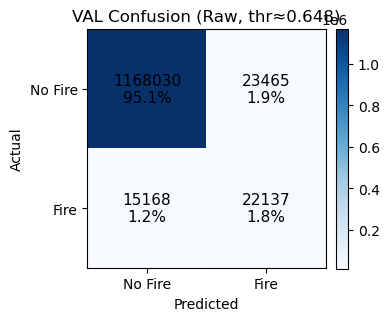

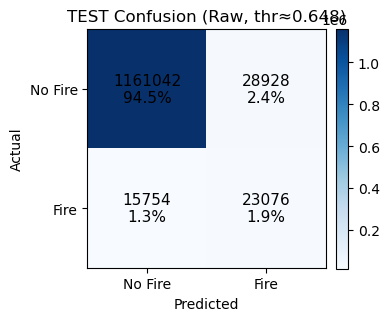

In [11]:
import numpy as np

best_name, best_stats = max(final_metrics.items(), key=lambda kv: kv[1]["val_ap"])
best_model = variants[best_name]
best_thr = best_stats["val_thr"]
print(f"Using {best_name} weights for confusion/PR with thr≈{best_thr:.3f}")

@torch.no_grad()
def confusion_at_thr(model_obj, loader, thr):
    model_obj.eval()
    tp = fp = tn = fn = 0
    for batch in loader:
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        p = torch.sigmoid(logits).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy().astype(np.uint8)
        p = np.nan_to_num(p, nan=0.0)
        yhat = (p >= thr).astype(np.uint8)
        tp += np.logical_and(yhat == 1, t == 1).sum()
        fp += np.logical_and(yhat == 1, t == 0).sum()
        tn += np.logical_and(yhat == 0, t == 0).sum()
        fn += np.logical_and(yhat == 0, t == 1).sum()
    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                precision=float(prec), recall=float(rec), f1=float(f1))

def _conf_matrix_from_counts(stats):
    return np.array([[stats["tn"], stats["fp"]],
                     [stats["fn"], stats["tp"]]], dtype=np.int32)

def _plot_confusion(cm, title):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No Fire", "Fire"])
    ax.set_yticklabels(["No Fire", "Fire"])
    for (i, j), val in np.ndenumerate(cm):
        pct = (val / total * 100.0) if total else 0.0
        ax.text(j, i, f"{val}\n{pct:.1f}%", ha="center", va="center", color="black", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()

val_stats = confusion_at_thr(best_model, val_loader, best_thr)
test_stats = confusion_at_thr(best_model, test_loader, best_thr)

print("VAL @thr:", val_stats)
print("TEST @thr:", test_stats)

_plot_confusion(_conf_matrix_from_counts(val_stats), f"VAL Confusion ({best_name}, thr≈{best_thr:.3f})")
_plot_confusion(_conf_matrix_from_counts(test_stats), f"TEST Confusion ({best_name}, thr≈{best_thr:.3f})")


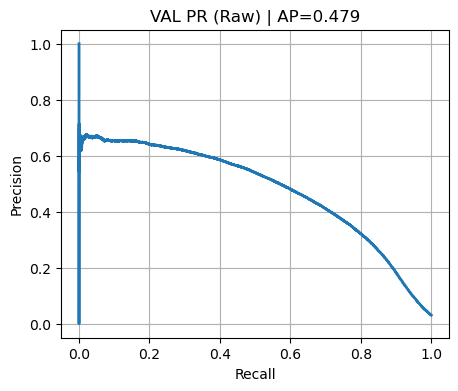

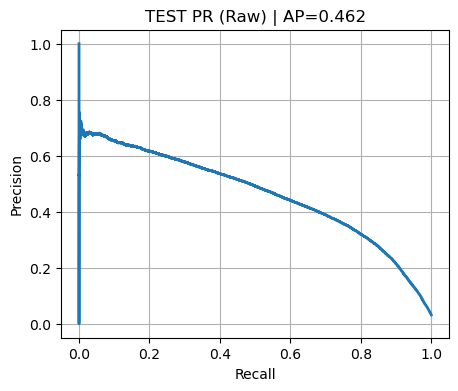

In [12]:
@torch.no_grad()
def pr_curve(model_obj, loader, title="PR Curve"):
    model_obj.eval()
    ps, ts = [], []
    for batch in loader:
        feats, y = _forward_batch(model_obj, batch)
        p = torch.sigmoid(model_obj(feats)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p)
        ts.append(t)
    p = np.concatenate(ps)
    t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True)
    plt.show()

pr_curve(best_model, val_loader, f"VAL PR ({best_name})")
pr_curve(best_model, test_loader, f"TEST PR ({best_name})")

TEST metrics: {'ap': 0.4616982474061869, 'best_f1': 0.5085236226145948, 'best_thr': 0.6167401075363159, 'chosen_thr': 0.6484948992729187}
Confusion counts: {'TP': 23076.0, 'FP': 28928.0, 'FN': 15754.0}
Confusion matrix:
 [[1161042   28928]
 [  15754   23076]]


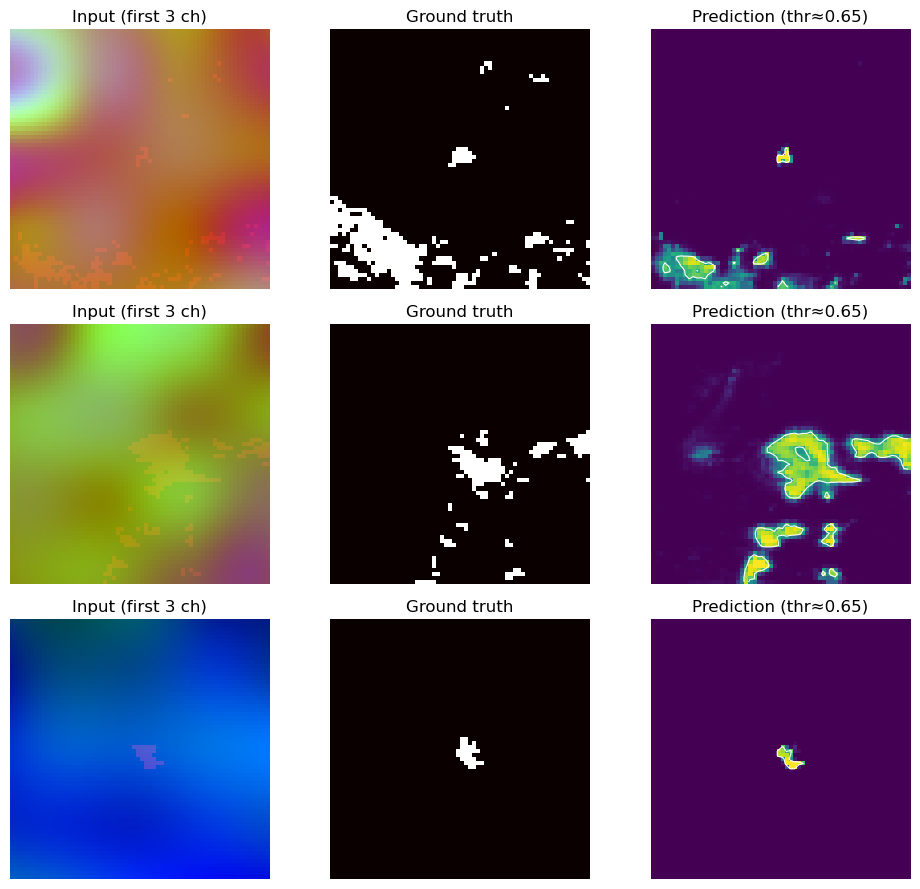

In [13]:
# =========================================================
# Test-set evaluation + qualitative checks
# =========================================================
@torch.no_grad()
def run_test(model_obj, loader, threshold=None, desc="TEST eval"):
    model_obj.eval()
    probs_all, targets_all = [], []
    for batch in tqdm(loader, desc=desc, leave=False):
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        probs_all.append(torch.sigmoid(logits).detach().cpu())
        targets_all.append(y.detach().cpu())
    probs = torch.cat(probs_all, dim=0)
    targets = torch.cat(targets_all, dim=0)
    p_flat = probs.flatten().numpy()
    t_flat = targets.flatten().numpy()
    ap = average_precision_score(t_flat, p_flat)
    prec, rec, thr = precision_recall_curve(t_flat, p_flat)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr_curve = thr[best_idx] if best_idx < len(thr) else 0.5
    chosen_thr = float(threshold if threshold is not None else best_thr_curve)
    binary = (probs >= chosen_thr).float()
    tp = float((binary * targets).sum().item())
    fp = float((binary * (1 - targets)).sum().item())
    fn = float((((1 - binary) * targets)).sum().item())
    metrics = {
        "ap": float(ap),
        "best_f1": float(f1.max()),
        "best_thr": float(best_thr_curve),
        "chosen_thr": chosen_thr,
    }
    confusion_counts = {"TP": tp, "FP": fp, "FN": fn}
    cm = confusion_matrix(t_flat.astype(int), binary.flatten().numpy().astype(int), labels=[0, 1])
    return metrics, confusion_counts, cm


test_metrics, test_confusion, test_cm = run_test(best_model, test_loader, threshold=best_thr, desc=f"TEST {best_name}")
print("TEST metrics:", test_metrics)
print("Confusion counts:", test_confusion)
print("Confusion matrix:\n", test_cm)


@torch.no_grad()
def visualize_predictions(loader, model_obj=None, n=4, threshold=None):
    if model_obj is None:
        model_obj = best_model
    thr = float(threshold if threshold is not None else test_metrics.get("chosen_thr", best_thr))
    loader_iter = iter(loader)
    fig, axes = plt.subplots(n, 3, figsize=(10, 3 * n))
    axes = np.atleast_2d(axes)
    for row in range(n):
        try:
            batch = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            batch = next(loader_iter)
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        prob = torch.sigmoid(logits).detach().cpu()
        x_raw = batch["X_raw"][0].cpu().numpy()
        img = x_raw[:3]
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        gt = y[0, 0].cpu().numpy()
        pred = prob[0, 0].numpy()
        axs = axes[row]
        axs[0].imshow(np.moveaxis(img, 0, -1))
        axs[0].set_title("Input (first 3 ch)")
        axs[0].axis("off")
        im1 = axs[1].imshow(gt, cmap="hot")
        axs[1].set_title("Ground truth")
        axs[1].axis("off")
        im2 = axs[2].imshow(pred, cmap="viridis")
        axs[2].contour(pred, levels=[thr], colors="white", linewidths=0.8)
        axs[2].set_title(f"Prediction (thr≈{thr:.2f})")
        axs[2].axis("off")
    plt.tight_layout()


visualize_predictions(test_loader, model_obj=best_model, n=3, threshold=test_metrics.get("chosen_thr", best_thr))

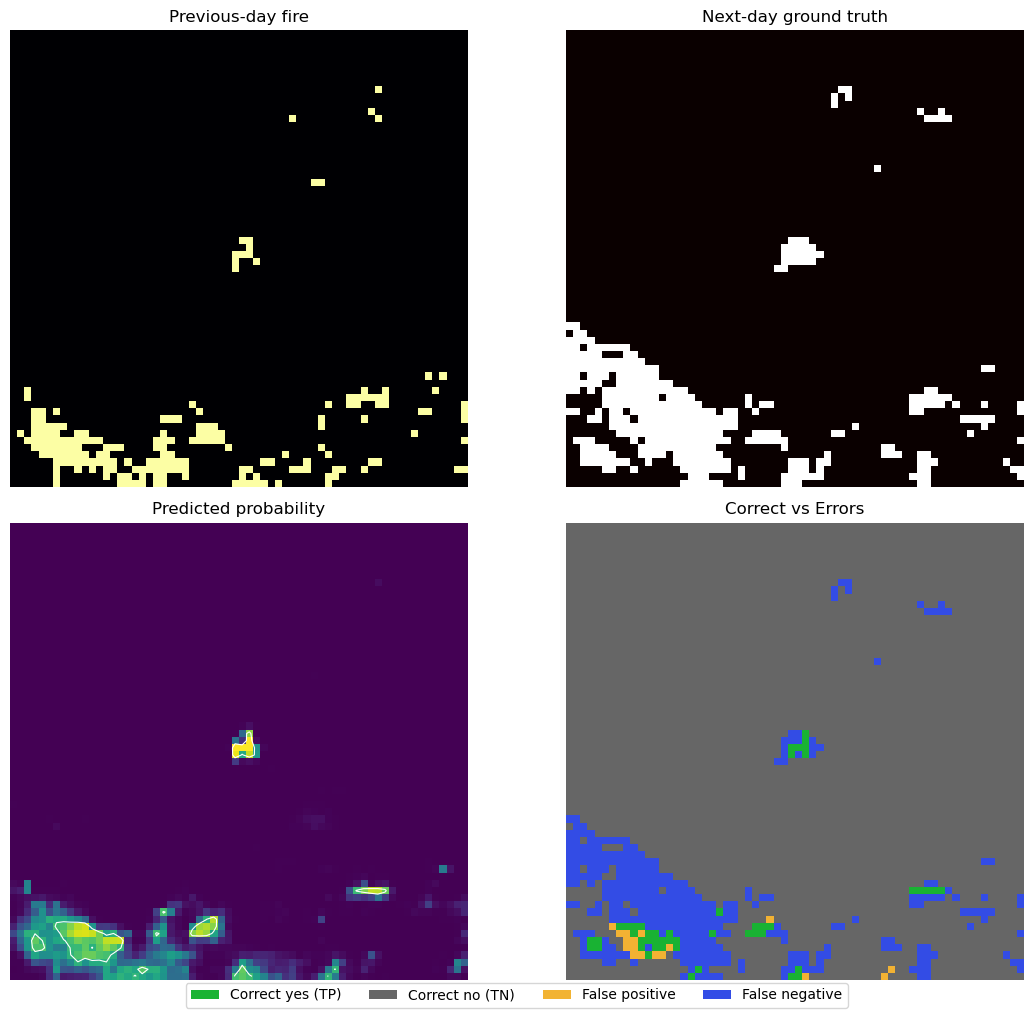

In [14]:
# =========================================================
# Single-tile error-type visualization
# =========================================================
@torch.no_grad()
def plot_error_breakdown(loader, model_obj=None, threshold=None):
    if model_obj is None:
        model_obj = best_model
    thr = float(threshold if threshold is not None else test_metrics.get("chosen_thr", best_thr))
    batch = next(iter(loader))
    feats, y = _forward_batch(model_obj, batch)
    logits = model_obj(feats)
    prob = torch.sigmoid(logits).detach().cpu().numpy()[0, 0]
    pred_mask = (prob >= thr).astype(np.float32)
    gt_mask = y[0, 0].cpu().numpy()
    channel_names = getattr(loader.dataset, "channels", CHANNELS_FOR_MODEL)
    prev_idx = channel_names.index("prev_fire") if "prev_fire" in channel_names else 0
    prev_fire = batch["X_raw"][0, prev_idx].cpu().numpy()
    prev_fire = (prev_fire - prev_fire.min()) / (prev_fire.max() - prev_fire.min() + 1e-6)

    correct_yes = np.logical_and(pred_mask == 1, gt_mask == 1)
    correct_no = np.logical_and(pred_mask == 0, gt_mask == 0)
    false_pos = np.logical_and(pred_mask == 1, gt_mask == 0)
    false_neg = np.logical_and(pred_mask == 0, gt_mask == 1)

    palette = {
        "TP": np.array([0.1, 0.7, 0.2]),
        "TN": np.array([0.4, 0.4, 0.4]),
        "FP": np.array([0.95, 0.7, 0.2]),
        "FN": np.array([0.2, 0.3, 0.9]),
    }
    error_map = np.zeros((*gt_mask.shape, 3), dtype=np.float32)
    error_map[correct_yes] = palette["TP"]
    error_map[correct_no] = palette["TN"]
    error_map[false_pos] = palette["FP"]
    error_map[false_neg] = palette["FN"]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes[0, 0].imshow(prev_fire, cmap="inferno")
    axes[0, 0].set_title("Previous-day fire")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(gt_mask, cmap="hot")
    axes[0, 1].set_title("Next-day ground truth")
    axes[0, 1].axis("off")

    axes[1, 0].imshow(prob, cmap="viridis")
    axes[1, 0].contour(prob, levels=[thr], colors="white", linewidths=0.8)
    axes[1, 0].set_title("Predicted probability")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(error_map)
    axes[1, 1].set_title("Correct vs Errors")
    axes[1, 1].axis("off")

    legend_patches = [
        Patch(facecolor=palette["TP"], edgecolor="none", label="Correct yes (TP)"),
        Patch(facecolor=palette["TN"], edgecolor="none", label="Correct no (TN)"),
        Patch(facecolor=palette["FP"], edgecolor="none", label="False positive"),
        Patch(facecolor=palette["FN"], edgecolor="none", label="False negative"),
    ]
    fig.legend(handles=legend_patches, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.02))
    plt.tight_layout()


plot_error_breakdown(test_loader, model_obj=best_model, threshold=test_metrics.get("chosen_thr", best_thr))